#### Рекомендательная система

Есть некоторый новостной сайт, на котором представлены разные статьи. Сейчас здесь нет какой-то серьезной рекомендательной системы, пользователю показываются все недавние статьи по популярности.  
На основе предоставленных данных, вам необходимо предсказать следующие 3 сайта, которые посетит каждый пользователь из тестового выборки. 

![](a.jpg)

In [2]:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import cm
import re
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

import itertools as it

In [3]:
import time
from tqdm.notebook import tqdm #from tqdm import tqdm
from ipywidgets import IntProgress
from sklearn import utils

In [4]:
import implicit

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

#### Загрузка и обработка данных

Обучающая выборка:

In [7]:
df_train = pd.read_csv(r'Data/train.csv', )
df_train.head()

,user_id,item_id,order
0,0,0,1
1,0,1,2
2,0,2,3
3,0,3,4
4,0,4,5


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705066 entries, 0 to 705065
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  705066 non-null  int64
 1   item_id  705066 non-null  int64
 2   order    705066 non-null  int64
dtypes: int64(3)
memory usage: 16.1 MB


Описания пользователя:

In [9]:
df_uf = pd.read_csv(r'Data/user-features.csv', )
df_uf.head()

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.959484,0.024890,0.119709,0.083119,0.049700,0.032604,-0.049732,0.005637,0.120104,0.125555,0.085036,0.084546,-0.024835,-0.038055,-0.045251,0.053042
1,1,0.968620,-0.035631,0.046282,0.045676,0.114160,0.018050,-0.003364,-0.032724,-0.076289,-0.056245,-0.077599,0.106774,0.061935,-0.015028,-0.106559,-0.003852
2,2,0.933710,0.030084,-0.039121,0.116893,0.130813,0.171836,0.030485,-0.054120,-0.056811,-0.007334,0.160973,0.109083,0.009491,0.127983,0.063371,0.003180
3,3,0.962006,-0.030586,-0.188485,0.012392,0.031410,0.057475,0.056365,-0.046878,0.029630,0.094262,-0.016992,-0.051303,-0.071980,-0.006859,0.095798,-0.034290
4,4,0.967180,0.095349,-0.036897,-0.048526,-0.009786,0.035573,0.009612,0.097665,-0.103747,0.075146,-0.052034,0.091168,0.069708,0.046377,0.068546,0.040315


In [10]:
df_uf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  15000 non-null  int64  
 1   0        15000 non-null  float64
 2   1        15000 non-null  float64
 3   2        15000 non-null  float64
 4   3        15000 non-null  float64
 5   4        15000 non-null  float64
 6   5        15000 non-null  float64
 7   6        15000 non-null  float64
 8   7        15000 non-null  float64
 9   8        15000 non-null  float64
 10  9        15000 non-null  float64
 11  10       15000 non-null  float64
 12  11       15000 non-null  float64
 13  12       15000 non-null  float64
 14  13       15000 non-null  float64
 15  14       15000 non-null  float64
 16  15       15000 non-null  float64
dtypes: float64(16), int64(1)
memory usage: 1.9 MB


In [11]:
df_uf

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.959484,0.024890,0.119709,0.083119,0.049700,0.032604,-0.049732,0.005637,0.120104,0.125555,0.085036,0.084546,-0.024835,-0.038055,-0.045251,0.053042
1,1,0.968620,-0.035631,0.046282,0.045676,0.114160,0.018050,-0.003364,-0.032724,-0.076289,-0.056245,-0.077599,0.106774,0.061935,-0.015028,-0.106559,-0.003852
2,2,0.933710,0.030084,-0.039121,0.116893,0.130813,0.171836,0.030485,-0.054120,-0.056811,-0.007334,0.160973,0.109083,0.009491,0.127983,0.063371,0.003180
3,3,0.962006,-0.030586,-0.188485,0.012392,0.031410,0.057475,0.056365,-0.046878,0.029630,0.094262,-0.016992,-0.051303,-0.071980,-0.006859,0.095798,-0.034290
4,4,0.967180,0.095349,-0.036897,-0.048526,-0.009786,0.035573,0.009612,0.097665,-0.103747,0.075146,-0.052034,0.091168,0.069708,0.046377,0.068546,0.040315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,0.966245,-0.004858,-0.091720,-0.069360,0.039728,-0.106269,0.037242,-0.028344,0.028944,0.058268,-0.068776,-0.043444,-0.085307,-0.082159,0.065187,0.094524
14996,14996,0.834114,0.196918,0.067103,0.128018,0.326857,-0.049361,0.024620,0.005111,-0.029306,0.022782,0.060534,0.105334,0.074484,0.244668,0.175922,0.148947
14997,14997,0.922118,0.032624,-0.079825,-0.071931,0.067914,-0.045672,0.073827,-0.084630,-0.242422,-0.035558,0.004221,-0.007509,0.002010,0.229047,0.013220,0.070915
14998,14998,0.986416,-0.069737,-0.009517,-0.015144,-0.064791,0.036025,-0.018166,-0.039688,0.049517,0.022008,0.068509,0.011268,0.018774,-0.068602,0.035840,-0.017300


Тестовая выборка:

In [12]:
df_test = pd.read_csv(r'Data/test.csv', )
df_test.head()

,user_id,order
0,0,1
1,0,2
2,0,3
3,1,1
4,1,2


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  45000 non-null  int64
 1   order    45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


Пропусков в данных нет, типы данных соответсвуют данным.

##### Визуализация данных

In [14]:
print("В нашей обучающей выборке ({}) уникальных пользователей и "\
      "({}) уникальных сйтов.".format(len(df_train["user_id"].unique()),
                                       len(df_train["item_id"].unique())))

В нашей обучающей выборке (15000) уникальных пользователей и (191) уникальных сйтов.


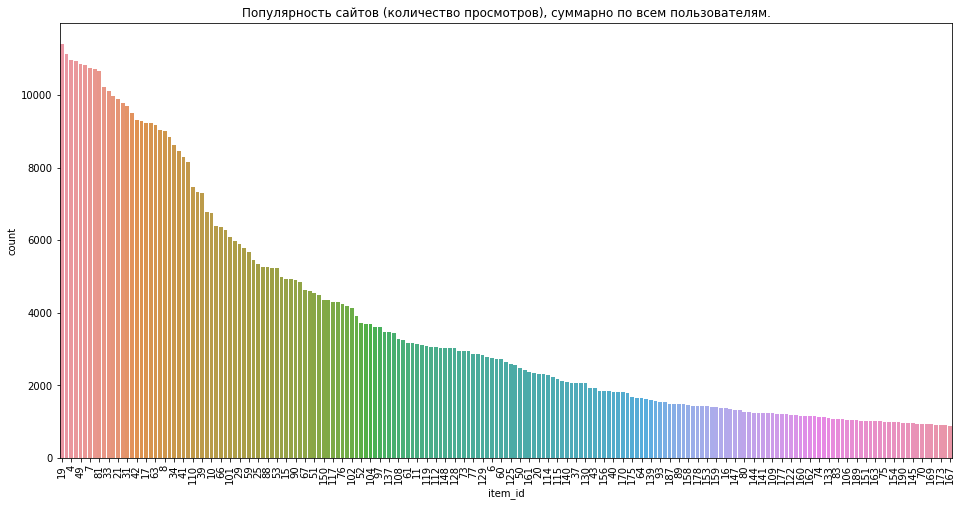

In [15]:
plt.figure(figsize=(16,8))
sns.countplot(data=df_train, x='item_id', order=df_train["item_id"].value_counts().index)
plt.title("Популярность сайтов (количество просмотров), суммарно по всем пользователям.")
plt.xticks(range(0,len(df_train["item_id"].unique()),2))
plt.xticks(rotation=90);

In [16]:
df_tt = pd.DataFrame(df_train.pivot_table(index='item_id', columns='order', aggfunc='count', fill_value=0).to_records())

In [17]:
df_tt.columns = list(range(0,66,1))
df_tt.drop(0, axis=1, inplace=True)

In [18]:
df_tt

,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
0,23,54,90,47,38,33,43,39,32,28,...,7,5,4,2,1,0,0,0,1,0
1,158,242,228,265,218,189,218,247,236,225,...,13,11,7,3,4,2,0,0,0,0
2,40,54,64,79,64,57,45,54,58,56,...,11,8,4,3,0,2,0,0,0,0
3,241,344,329,299,286,289,321,304,282,315,...,19,8,7,0,2,1,0,0,0,0
4,223,290,282,290,275,285,294,288,286,276,...,18,9,9,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,14,10,18,21,22,10,10,15,27,21,...,0,1,2,0,0,1,0,0,0,0
187,14,35,27,25,19,32,20,22,27,21,...,5,3,3,4,0,0,0,0,0,0
188,16,41,13,21,10,15,16,21,11,15,...,2,0,1,2,2,1,1,0,0,0
189,5,13,21,19,20,7,19,12,18,26,...,5,3,3,3,1,1,0,0,0,0


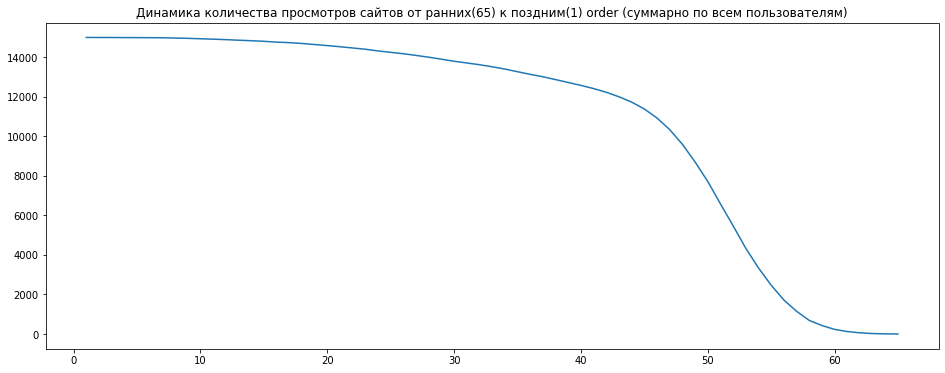

In [19]:
df_tt.sum().plot(figsize=(16,6))
plt.title("Динамика количества просмотров сайтов от ранних(65) к поздним(1) order (суммарно по всем пользователям)");

In [20]:
df_tt[65].value_counts()

0    190
1      1
Name: 65, dtype: int64

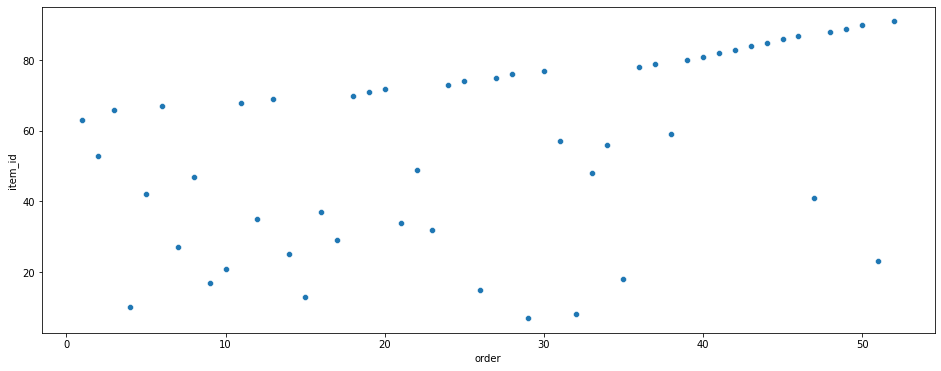

In [21]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=df_train[df_train['user_id'] == 1][['item_id', 'order']],
               x='order', y='item_id');

In [22]:
df_train[df_train['user_id'] == 14999]['item_id'].value_counts()

32     1
19     1
76     1
21     1
67     1
92     1
51     1
45     1
57     1
35     1
85     1
104    1
8      1
24     1
112    1
48     1
56     1
84     1
65     1
29     1
69     1
27     1
124    1
160    1
49     1
46     1
42     1
53     1
13     1
66     1
123    1
7      1
33     1
50     1
52     1
31     1
26     1
15     1
5      1
1      1
98     1
81     1
148    1
14     1
17     1
74     1
34     1
99     1
41     1
102    1
16     1
63     1
3      1
Name: item_id, dtype: int64

Можно добавить фичу - статьи которые он вообще не смотрел и получается вряд ли посмотрит

А есть ли пользователи, которые смотрели одни и теже сайты больше 1 раза?

In [23]:
df_item_gt1 = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id', 
                                                aggfunc='count', fill_value=0).to_records())

df_item_gt1.drop('user_id', axis=1, inplace=True)
df_item_gt1.columns = list(range(0,191,1))

df_item_gt1

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1,1,0,1,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
14996,0,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,1,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
14998,0,0,0,1,0,0,1,1,1,0,...,1,0,0,0,0,0,1,0,0,0


In [24]:
df_item_gt1[df_item_gt1 >1].sum().sort_values(ascending=True)

0      0.0
121    0.0
122    0.0
123    0.0
124    0.0
      ... 
66     0.0
67     0.0
68     0.0
59     0.0
190    0.0
Length: 191, dtype: float64

In [25]:
for index, row in df_item_gt1.head().iterrows():
    if row.sort_values(ascending=False)[0] > 0:
        print(row.sort_values(ascending=False))

0      1
29     1
31     1
32     1
33     1
      ..
93     0
92     0
91     0
90     0
190    0
Name: 0, Length: 191, dtype: int64


Это говорит о том, что ни один пользователь не посмотрел один и тот же сайт дважды? Значит просмотренные сайты можно вообще исключить из прогноза для пользователя.

Есть пользователи, которые вообще ничего не смотрели?

In [26]:
df_item_gt1.sum(axis=1).sort_values()

1051      1
13272     2
3411      3
11196     3
344       3
         ..
5726     64
4046     64
11217    64
9914     64
1192     65
Length: 15000, dtype: int64

Возможно количество просмотров у каждого пользователя можно использовать как фичу

In [27]:
df_train[df_train['user_id'] == 13272]

,user_id,item_id,order
623204,13272,150,1
623205,13272,54,2


In [28]:
df_uf

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.959484,0.024890,0.119709,0.083119,0.049700,0.032604,-0.049732,0.005637,0.120104,0.125555,0.085036,0.084546,-0.024835,-0.038055,-0.045251,0.053042
1,1,0.968620,-0.035631,0.046282,0.045676,0.114160,0.018050,-0.003364,-0.032724,-0.076289,-0.056245,-0.077599,0.106774,0.061935,-0.015028,-0.106559,-0.003852
2,2,0.933710,0.030084,-0.039121,0.116893,0.130813,0.171836,0.030485,-0.054120,-0.056811,-0.007334,0.160973,0.109083,0.009491,0.127983,0.063371,0.003180
3,3,0.962006,-0.030586,-0.188485,0.012392,0.031410,0.057475,0.056365,-0.046878,0.029630,0.094262,-0.016992,-0.051303,-0.071980,-0.006859,0.095798,-0.034290
4,4,0.967180,0.095349,-0.036897,-0.048526,-0.009786,0.035573,0.009612,0.097665,-0.103747,0.075146,-0.052034,0.091168,0.069708,0.046377,0.068546,0.040315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,0.966245,-0.004858,-0.091720,-0.069360,0.039728,-0.106269,0.037242,-0.028344,0.028944,0.058268,-0.068776,-0.043444,-0.085307,-0.082159,0.065187,0.094524
14996,14996,0.834114,0.196918,0.067103,0.128018,0.326857,-0.049361,0.024620,0.005111,-0.029306,0.022782,0.060534,0.105334,0.074484,0.244668,0.175922,0.148947
14997,14997,0.922118,0.032624,-0.079825,-0.071931,0.067914,-0.045672,0.073827,-0.084630,-0.242422,-0.035558,0.004221,-0.007509,0.002010,0.229047,0.013220,0.070915
14998,14998,0.986416,-0.069737,-0.009517,-0.015144,-0.064791,0.036025,-0.018166,-0.039688,0.049517,0.022008,0.068509,0.011268,0.018774,-0.068602,0.035840,-0.017300


### Разобью пользователей на кластеры

Прежде чем работать с метрическими алгоритмами нужно отмасштабировать данные.

In [20]:
scaler = MinMaxScaler(feature_range=(0,1)) 
df_uf_scaled = scaler.fit_transform(df_uf.drop('user_id', axis=1))

Понижаю размерность до 2 чтобы визуализировать текущие данные по пользователям

In [21]:
%%time
pca = PCA(n_components=2, random_state=42)
df_uf_pca = pca.fit_transform(df_uf_scaled)

CPU times: user 110 ms, sys: 35.4 ms, total: 145 ms
Wall time: 62.3 ms


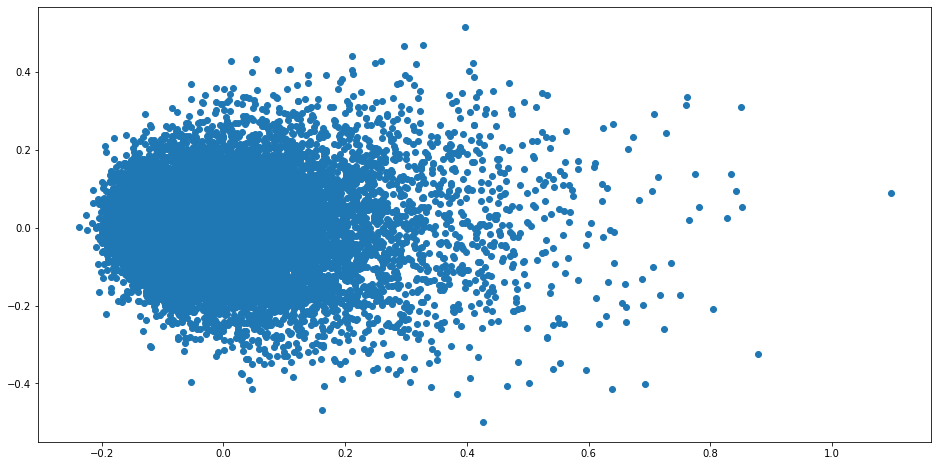

In [45]:
plt.figure(figsize=(16,8))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1])#,c=clf.labels_)

In [595]:
%%time
#tsne = TSNE(n_components=2, init='pca', random_state=42)

#X_reduced_tsne = tsne.fit_transform(df_uf)
#print(X_reduced_tsne.shape)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


Определяю количество кластеров.

Метод коэффицинет силуэта

In [46]:
def draw_sil(X, range_n_clusters = [2, 3, 4, 5, 6]):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

In [47]:
def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 14, 15, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    plt.xticks(range(0, len(range_n_clusters)+1 , 1))
    plt.grid(alpha=0.35)
    return print('\n\n shape: {}, max_score_cluster: {}'.format(X.shape, range_n_clusters[np.argmax(scores)]))

In [48]:
def draw_sil_score_n_components(data, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 14, 15, 20], n_components=range(4,10)): 
    '''
    Строит графики очков коэффициента силуэта по всем РСА и всей выборке количества кластеров
    '''
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    i=0

    for row, row_axes in enumerate(axes):
      for column, ax in enumerate(row_axes):
        pca = PCA(n_components=n_components[i], random_state=42)
        X = pca.fit_transform(data)
        scores = []
        for n_clusters in range_n_clusters:
          clusterer = KMeans(n_clusters=n_clusters, random_state=10)
          cluster_labels = clusterer.fit_predict(X)
          silhouette_avg = silhouette_score(X, cluster_labels)
          scores.append(silhouette_avg)     
        ax.plot(range_n_clusters, scores)
        ax.set_xticks(range(0, len(range_n_clusters)+1 , 1))
        ax.set_title('shape: {}, max_score_cluster: {}'.format(X.shape, range_n_clusters[np.argmax(scores)]))
        ax.grid(alpha=0.35)

        i+=1

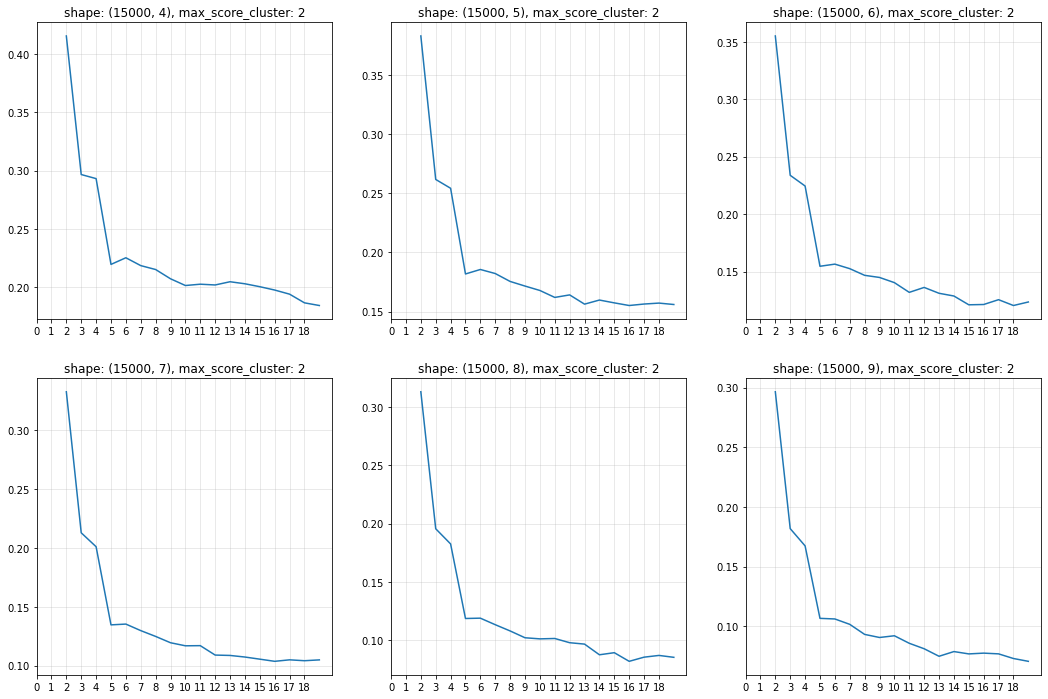

In [304]:
n_components_range = range(4,15)
n_clusters_range =range(2,20)

draw_sil_score_n_components(df_uf_scaled, range_n_clusters=n_clusters_range, n_components=n_components_range)

  0%|          | 0/14 [00:00<?, ?it/s]



 shape: (15000, 16), max_score_cluster: 2


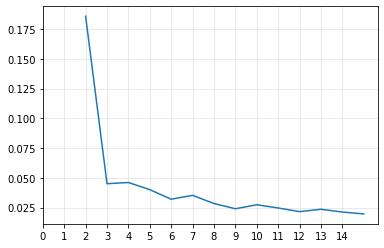

In [599]:
draw_sil_score(df_uf_scaled, range(2,16))

сумма квадратов расстояний от точек до центроидов кластеров:

In [600]:
inertia = []
N = 20
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_uf_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

  0%|          | 0/19 [00:00<?, ?it/s]

PCA


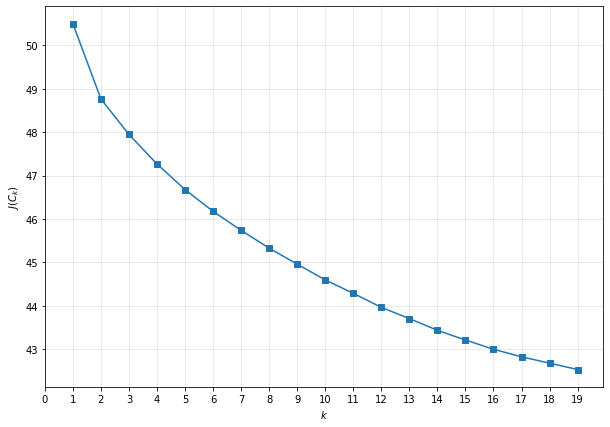

In [601]:
print('PCA')
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.xticks(range(0, N , 1))
plt.grid(alpha=0.35)
pass

Наиболее подходящее число кластеров 3,4,5,6

In [602]:
clf = KMeans(n_clusters=3)
clf.fit(df_uf_pca)

KMeans(n_clusters=3)

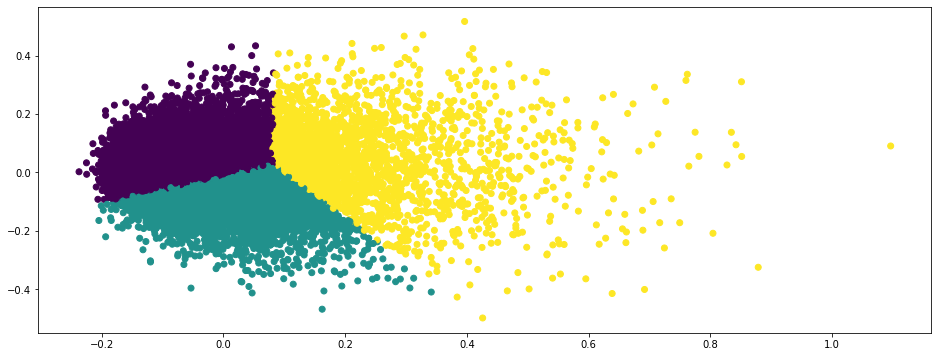

In [603]:
plt.figure(figsize=(16,6))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1],c=clf.labels_)

In [604]:
clf = KMeans(n_clusters=4)
clf.fit(df_uf_pca)

KMeans(n_clusters=4)

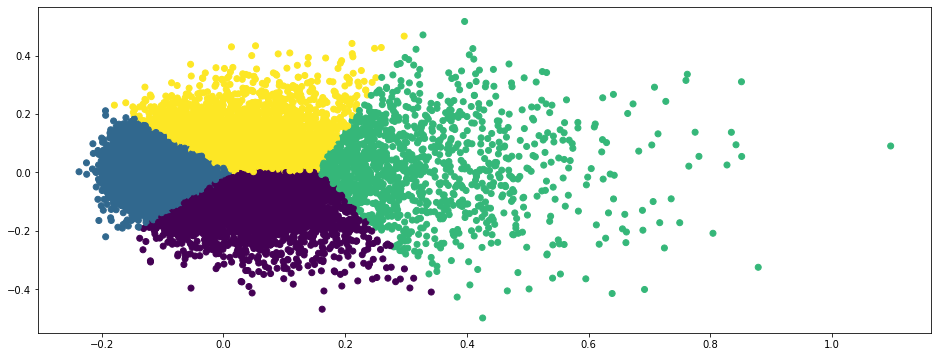

In [605]:
plt.figure(figsize=(16,6))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1],c=clf.labels_)

In [606]:
clf = KMeans(n_clusters=5)
clf.fit(df_uf_pca)

KMeans(n_clusters=5)

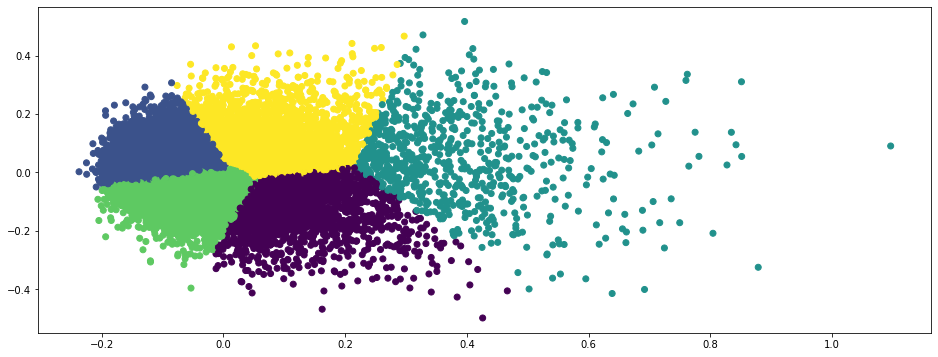

In [607]:
plt.figure(figsize=(16,6))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1],c=clf.labels_)

In [608]:
clf = KMeans(n_clusters=6)
clf.fit(df_uf_pca)

KMeans(n_clusters=6)

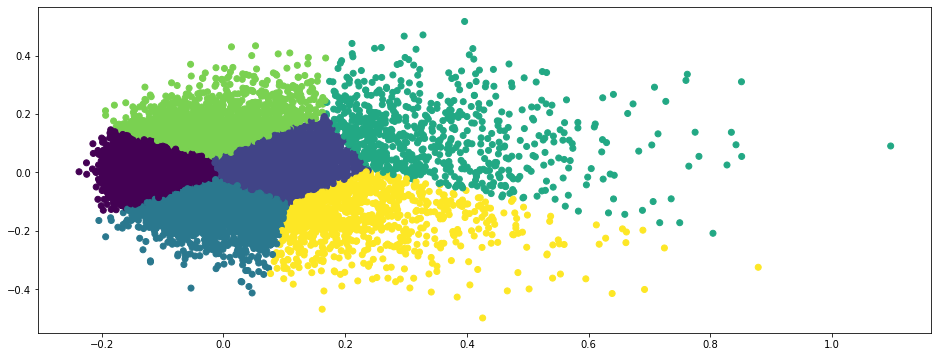

In [609]:
plt.figure(figsize=(16,6))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1],c=clf.labels_)

Подготовка к предсказанию

In [49]:
#Добавлю новые столбцы с кластерами
for n in range(3,7):
    clf = KMeans(n_clusters=n)
    clf.fit(df_uf_pca)
    df_uf['Kmeans{}'.format(n)] = clf.labels_

In [50]:
df_uf

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,Kmeans3,Kmeans4,Kmeans5,Kmeans6
0,0,0.959484,0.024890,0.119709,0.083119,0.049700,0.032604,-0.049732,0.005637,0.120104,...,0.085036,0.084546,-0.024835,-0.038055,-0.045251,0.053042,0,0,2,0
1,1,0.968620,-0.035631,0.046282,0.045676,0.114160,0.018050,-0.003364,-0.032724,-0.076289,...,-0.077599,0.106774,0.061935,-0.015028,-0.106559,-0.003852,2,3,0,3
2,2,0.933710,0.030084,-0.039121,0.116893,0.130813,0.171836,0.030485,-0.054120,-0.056811,...,0.160973,0.109083,0.009491,0.127983,0.063371,0.003180,0,0,2,0
3,3,0.962006,-0.030586,-0.188485,0.012392,0.031410,0.057475,0.056365,-0.046878,0.029630,...,-0.016992,-0.051303,-0.071980,-0.006859,0.095798,-0.034290,0,3,3,0
4,4,0.967180,0.095349,-0.036897,-0.048526,-0.009786,0.035573,0.009612,0.097665,-0.103747,...,-0.052034,0.091168,0.069708,0.046377,0.068546,0.040315,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,0.966245,-0.004858,-0.091720,-0.069360,0.039728,-0.106269,0.037242,-0.028344,0.028944,...,-0.068776,-0.043444,-0.085307,-0.082159,0.065187,0.094524,0,3,3,5
14996,14996,0.834114,0.196918,0.067103,0.128018,0.326857,-0.049361,0.024620,0.005111,-0.029306,...,0.060534,0.105334,0.074484,0.244668,0.175922,0.148947,1,1,4,4
14997,14997,0.922118,0.032624,-0.079825,-0.071931,0.067914,-0.045672,0.073827,-0.084630,-0.242422,...,0.004221,-0.007509,0.002010,0.229047,0.013220,0.070915,0,3,0,3
14998,14998,0.986416,-0.069737,-0.009517,-0.015144,-0.064791,0.036025,-0.018166,-0.039688,0.049517,...,0.068509,0.011268,0.018774,-0.068602,0.035840,-0.017300,0,3,3,5


Посмотрим на тех, кто мало открывал статей на сайте, в одном ли они кластере?

In [51]:
df_item_gt1.sum(axis=1).sort_values()

1051      1
13272     2
3411      3
11196     3
344       3
         ..
5726     64
4046     64
11217    64
9914     64
1192     65
Length: 15000, dtype: int64

In [52]:
df_uf[df_uf['user_id'] == 1051]['Kmeans5']

1051    4
Name: Kmeans5, dtype: int32

In [53]:
df_uf[df_uf['user_id'] == 13272]['Kmeans5']

13272    4
Name: Kmeans5, dtype: int32

In [54]:
df_uf[df_uf['user_id'] == 3411]['Kmeans5']

3411    4
Name: Kmeans5, dtype: int32

In [55]:
df_uf[df_uf['user_id'] == 11196]['Kmeans5']

11196    4
Name: Kmeans5, dtype: int32

In [56]:
df_uf[df_uf['user_id'] == 344]['Kmeans5']

344    4
Name: Kmeans5, dtype: int32

 Пользователи с малым количеством просмотров в одном кластере, это хорошо

Сколько просмотров в каждом кластере

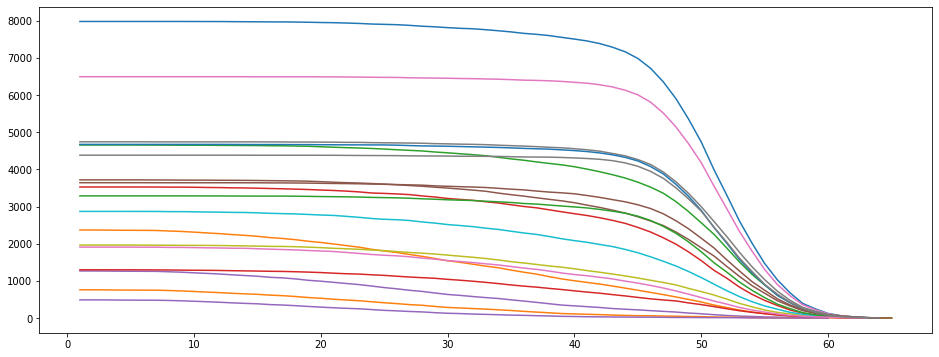

In [57]:
for n in range(3,7):
    for k in range(n):
        user_id_tmp = df_uf[df_uf['Kmeans{}'.format(n)] == k]['user_id'].values
        data = df_train[df_train['user_id'].isin(user_id_tmp)]
        df_tt_k_tmp = pd.DataFrame(data.pivot_table(index='item_id'
                                                    , columns='order'
                                                    , aggfunc='count'
                                                    , fill_value=0).to_records())
        df_tt_k_tmp.columns = list(range(0,len(df_tt_k_tmp.columns),1))
        df_tt_k_tmp.drop(0, axis=1, inplace=True)
        df_tt_k_tmp.sum().plot(figsize=(16,6))

В каждых кластерах просматриваются все order, но меняется количество просмотров и почти у всех после 45 order наблюдается снижение количества просмотров или снижается наличие данных по просмотрам.  

А какие пользователи вообще в тестовых данных? Есть там ИД которыех нет в обучающей выборке?

In [621]:
set(df_test['user_id']) - set(df_train['user_id'])

set()

Все пользователи есть и в трейне и в тесте и их количество равно

Таблица, где в строках пользователи, в столбцах ИД статей а в данных порядок в котором пользователь открывал статьи. Если не смотрел то -1

In [58]:
df_train_X = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id', 
                                                aggfunc='sum', fill_value=-1).to_records())
df_train_X.drop('user_id', axis=1, inplace=True)
df_train_X.columns = list(range(0,len(df_train_X.columns),1))

df_train_X

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1,2,3,4,5,6,7,8,9,10,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,29,32,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,43,4,24,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,21,-1,13,45,11,-1,31,33,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,1,-1,-1,12,-1,-1,46,44,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,47,38,-1,12,6,1,-1,31,-1,-1,...,18,-1,-1,-1,-1,-1,-1,-1,-1,-1
14996,-1,15,27,8,33,19,-1,20,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14997,-1,-1,-1,-1,-1,10,40,12,-1,-1,...,-1,-1,37,25,-1,-1,-1,-1,-1,-1
14998,-1,-1,-1,20,-1,-1,10,5,51,-1,...,37,-1,-1,-1,-1,-1,15,-1,-1,-1


Таблица, где в строках пользователи, в столбцах порядок просмотра статей пользователем, а в данных ИД статьи. Если не смотрел то -1

In [192]:
df_train_X_order = pd.DataFrame(df_train.pivot_table(index='user_id', columns='order', values='item_id', 
                                                aggfunc='sum', fill_value=-1).to_records())
df_train_X_order.drop('user_id', axis=1, inplace=True)
df_train_X_order

,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
0,0,1,2,3,4,5,6,7,8,9,...,55,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,63,53,66,10,42,67,27,47,17,21,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,7,14,58,3,27,65,48,63,17,94,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,116,117,44,115,33,57,34,19,46,47,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,1,65,126,127,27,31,120,110,26,51,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,5,98,44,52,141,4,152,81,29,73,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14996,150,90,57,81,24,27,101,3,17,114,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14997,26,22,57,62,19,110,92,56,34,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14998,33,116,66,108,7,32,25,13,47,6,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Разделю пользователей по количеству просмотренных статей

In [193]:
df_view_count = pd.DataFrame(df_train.pivot_table(index='user_id', columns='order', values='item_id', 
                                                aggfunc='count', fill_value=0).to_records())
df_view_count.drop('user_id', axis=1, inplace=True)
df_view_count

,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
0,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14996,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14997,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14998,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df_view_count['view_count'] = df_view_count.sum(axis=1).values

In [62]:
n=15
df_view_count['view_q'] = pd.qcut(df_view_count['view_count'], q=n, precision=0, labels=range(n))

/Users/denis/Environments/ds_3.8_prices/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


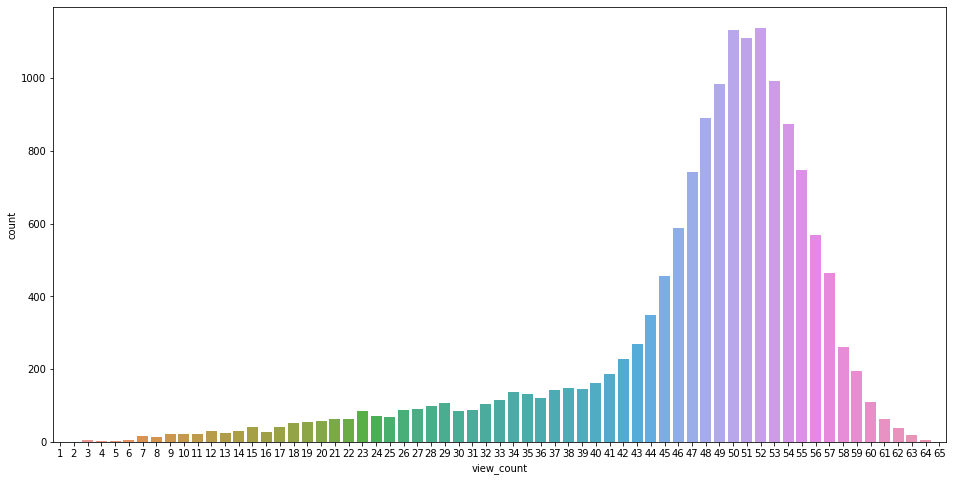

In [63]:
plt.figure(figsize=(16,8))
sns.countplot(df_view_count['view_count']);

/Users/denis/Environments/ds_3.8_prices/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='view_q', ylabel='count'>

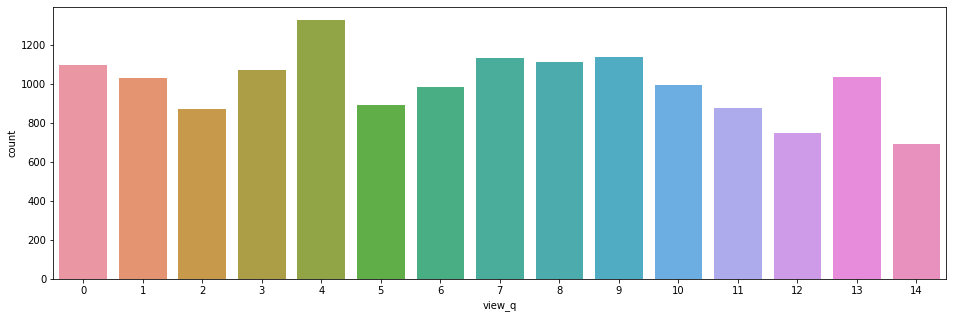

In [64]:
plt.figure(figsize=(16,5))
sns.countplot(df_view_count['view_q'])

Рейтинги статей (количество просмотров поделенные на количество пользователей)

In [194]:
df_item_id_rate = pd.DataFrame(df_train.pivot_table(index='item_id', columns='user_id', values='order', 
                                                aggfunc='count', fill_value=0).to_records())
df_item_id_rate.drop('item_id', axis=1, inplace=True)
df_item_id_rate

,0,1,2,3,4,5,6,7,8,9,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,0,0,0
1,1,0,0,1,1,0,1,1,1,0,...,1,0,1,0,1,1,1,0,0,1
2,1,0,1,0,0,1,1,0,0,1,...,0,0,0,1,1,0,1,0,0,0
3,1,0,1,1,0,0,0,0,1,1,...,1,1,0,1,1,1,1,0,1,1
4,1,0,1,1,1,1,1,0,1,1,...,1,1,0,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [195]:
df_item_id_rate['item_rate'] = df_item_id_rate.sum(axis=1).values / len(df_train['user_id'].unique())

In [196]:
df_item_id_rate[['item_rate']]

,item_rate
0,0.108733
1,0.617867
2,0.228467
3,0.741933
4,0.731267
...,...
186,0.064933
187,0.099600
188,0.068400
189,0.068533


#### Валидационная выборка

В качестве валидационной выборки возьму 3 последних посещения у каждого пользователя.  
Тех пользователей у которых меньше N посещений пока уберу в сторону

In [314]:
df_valid = pd.DataFrame(columns=['user_id', 'order', 'item_id'])
df_valid

,user_id,order,item_id


In [315]:
valid_ui = [] # user_id
valid_o = []  # order
valid_i = []  # item_id
train_index = []  # индексы строк из тренировочной выборке, которые станут валидационными
bad_users_id = [] # ид пользователей где меньше 4 посещений

for u_id in df_train['user_id'].unique():
    u_items_valid = df_train[df_train['user_id'] == u_id]['item_id'][-4:]
    if len(u_items_valid) > 3: #если есть хотябы 4 посещения (1-для прездсказания следущих, 3-для валидации)   
        order = 0
        for index, item in u_items_valid[-3:].items(): #беру 3 последних посещения для каждого пользователя
            order+=1
            valid_ui.append(u_id)
            valid_o.append(order)
            valid_i.append(item)
            train_index.append(index)
    else:
        bad_users_id.append(u_id)

In [316]:
df_valid['user_id'] = valid_ui
df_valid['order'] = valid_o
df_valid['item_id'] = valid_i

In [317]:
bad_users_id

[344, 1051, 3411, 5611, 11196, 13272]

In [318]:
df_valid

,user_id,order,item_id
0,0,1,53
1,0,2,54
2,0,3,55
3,1,1,90
4,1,2,23
...,...,...,...
44977,14998,2,8
44978,14998,3,24
44979,14999,1,160
44980,14999,2,49


Теперь нужно вычистить валидационные данные из тренировочных, сформирую новую тренировочную выборку.  
Для этого объединю валидационные данные с тренировочными и удалю дубликаты, тем самым в тренировочных данных останутся только не повторяющиеся значения.

In [34]:
df_train_sh = df_train.drop(train_index )

In [35]:
print('Тренировочные данные ({}) - валидационные ({}) = ({}). Новые тренировочные = ({})'.format(
                    df_train.shape[0], df_valid.shape[0], df_train.shape[0]-df_valid.shape[0], df_train_sh.shape[0]))

Тренировочные данные (705066) - валидационные (44982) = (660084). Новые тренировочные = (660084)


### Метрика качества

В качестве метрики для оценивания качества используется метрика ранжирования mean average precision at k (MAP@k) при k=3. То есть в метрике будут участвовать только 3 первых предсказания. На лидерборде показывается метрика умноженная на 10000, то есть результат будет выглядеть как 10000 * MAP@k.

Расчет данной метрики можно представить в три этапа:

1. Считаем precision at k:

Precision@k= 1/k ∑i=0 to k(Yitrue==Yipred)
2. Считаем average precision at k:

AP@k= 1/k ∑i=0 to k(Yitrue==Yipred)∗Precision@i
3. Берем среднее от average precision at k:

MAP@k= 1/N ∑i=0 to N (AP@k)
Чтобы реализовать данную функцию локально можно использовать следующий алгоритм.

На вход нам приходят два pd.DataFrame gt и preds с колонками [user_id, item_id, order]. gt – ground truth, то есть настоящие данные, а preds – наши предсказания. Тогда мы можем использовать следующие шаги для расчета метрики.

1. Отфильтровать gt и preds по колонке order, чтобы его значение было не больше k (порядка k в MAP@k).

2. Сджойнить два датафрейма по user_id и order. Здесь нам важно сохранить информацию о том, какой item_id на каком месте был для каждого пользователя.

После этих шагов мы готовы к расчету метрик по трем вышеописанным шагам для расчета MAP@k

3. Добавим в объединенный датафрейм (joined) колонку is_right, показывающую, что на текущем месте ответ был правильным. 4. Так как для расчета precision@k нам нужно знать количество всех правильных событий до текущего момента, то посчитаем кумулятивную сумму колонки is_right в разрезе по пользователям. Назовем ее is_right_cum.

5. Теперь посчитаем precision@k поделив колонку is_right_cum на order. То есть разделим количество правильно угаданных событий на количество всех событий до текущего момента.

6. В AP@k участвуют только те precision@k, для которых в текущий момент времени был правильно угадан ответ. Поэтому мы можем добавить еще одну колонку p@k_masked, которая является перемножением p@k на is_right.

7. Посчитаем среднее в разрезе каждого пользователя по колонке p@k_masked, получим AP@k для каждого пользователя.

8. Теперь возьмем глобальное среднее по AP@k и получим итоговую метрику MAP@k.

In [36]:
def calc_map_k(gt: pd.DataFrame, preds: pd.DataFrame, k=3) -> float:
    # filter first k elements of ground truth
    gt = gt[gt.order <= k]
    # filter first k elements of predictions
    preds = preds[preds.order <= k]
    # join ground truth and predictions by user_id and order, fill missed values from predictions by some non-existent value
    joined = gt.merge(preds, how="left", on=['user_id', "order"]).fillna(-12345)
    # create indicator of right predictions
    joined["is_right"] = (joined.item_id_x == joined.item_id_y).astype(int)
    # calculate cumulative sum of all right predictions before current order
    joined["is_right_cum"] = joined.groupby("user_id").is_right.cumsum()
    # normalize it by order (precision@k)
    joined["p@k"] = joined["is_right_cum"] / joined["order"]
    # add relevance mask
    joined["p@k_masked"] = joined["p@k"] * joined["is_right"]
    # calculate mean user based (average precision @ k)
    ap = joined.groupby("user_id")["p@k_masked"].mean()
    # calculate mean average precision @ k
    return ap.mean()

Проверка:

In [37]:
calc_map_k(df_valid, df_valid) *1000

1000.0

### baseline

В качестве бейзлайна буду для каждого пользователя брать его последнее посещение, выбирать всех пользователей кто посещал такую же статью, выбирать следующую статью которые посетили другие пользователи, выбирать из них самую популярную (по количеству посещений), вычищать из ниж ид статей которые уже просмотрел пользователь (т.к. по вбыорке я знаю что 2 раза пользователи не смотрят одну и ту же статью) и то что осталось то и рекомендовать.

Пример для пользователя с ИД = 0

In [364]:
user0_last_item_id = df_train_sh[df_train_sh['user_id'] == 0][-1:]["item_id"].values[0]
print("последняя просмотренная статья:{}".format(user0_last_item_id))

последняя просмотренная статья:52


In [365]:
#статьи которые уже просмотрел
user0_show_item_id = df_train_sh[df_train_sh['user_id'] == 0]["item_id"].values
len(user0_show_item_id)

53

In [366]:
user0_show_item_id

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52])

Пользователь с ИД = 3 тоже смотрел 52 статью

In [367]:
df_train_sh[(df_train_sh['user_id'] == 3) & (df_train_sh['item_id'] == user0_last_item_id)]

,user_id,item_id,order
189,3,52,30


In [368]:
df_train_sh[(df_train_sh['user_id'] == 3) & (df_train_sh['item_id'] == user0_last_item_id)]

,user_id,item_id,order
189,3,52,30


А после нее он смотрел статью с ИД 7, но она уже есть в просмотренных пользователем 0, значит не подходит

In [369]:
df_train_sh[(df_train_sh['user_id'] == 3) & (df_train_sh['order'] == 31)]

,user_id,item_id,order
190,3,7,31


In [370]:
7 in user0_show_item_id

True

А вот пользователь с ИД 9 после 52 смотрел 53, это подходит.

In [371]:
df_train_sh[(df_train_sh['user_id'] == 9) & (df_train_sh['item_id'] == user0_last_item_id)]

,user_id,item_id,order
471,9,52,16


In [372]:
df_train_sh[(df_train_sh['user_id'] == 9) & (df_train_sh['order'] == 17)]

,user_id,item_id,order
472,9,53,17


In [373]:
53 in user0_show_item_id

False

Есть пользователи которые смотрят статьи по очереди по ИД статьи (1,2,3 и т.д.), например пользователь с ИД 0. Для таких пользователей явно нужно рекомендовать просто следующую по порядку.  
Стоит поискать пользователей у которых серия последних просмотренных статей по порядку к примеру N(3,5,10) и для них рекомендовать просто следующую.

Можно еще попробовать обучить какую то модель которая сможет по ряду пользователя определеять следующее число, как у пользователя 0 где линейная завсимость.

Матрица пользователей и просмотренных статей.  
По ней буду отбирать ИД пользователей которые смотрели такую же статью.

In [430]:
df_user_item = pd.DataFrame(df_train_sh.pivot_table(index='user_id', columns='item_id', 
                                                aggfunc='sum', fill_value=-1).to_records())
df_user_item .drop('user_id', axis=1, inplace=True)
df_user_item.columns = list(range(0,len(df_user_item.columns),1))

df_user_item

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1,2,3,4,5,6,7,8,9,10,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,29,32,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,43,4,24,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,21,-1,13,-1,11,-1,31,33,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,1,-1,-1,12,-1,-1,46,44,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,-1,38,-1,12,6,1,-1,31,-1,-1,...,18,-1,-1,-1,-1,-1,-1,-1,-1,-1
14996,-1,15,27,8,33,19,-1,20,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14997,-1,-1,-1,-1,-1,10,40,12,-1,-1,...,-1,-1,37,25,-1,-1,-1,-1,-1,-1
14998,-1,-1,-1,20,-1,-1,10,5,-1,-1,...,37,-1,-1,-1,-1,-1,15,-1,-1,-1


In [629]:
#k=20
#clf = KMeans(n_clusters=k, n_jobs=-1)
#clf.fit(df_uf_pca)
#df_uf['Kmeans{}'.format(k)] = clf.labels_

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [431]:
k=100
clf = KMeans(n_clusters=k, n_jobs=-1)
clf.fit(df_user_item)
df_uf['Kmeans{}'.format(k)] = clf.labels_

/Users/denis/Environments/ds_3.8_prices/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [432]:
recomendaciones = [] #рекомендации

In [360]:
%%time
# для каждого пользователя нахожу похожего и смотрю какую статью читали похожие после последней статьи исходного пользователя и каких больше такую и рекомендую

o=3 #количетсво требуемых рекомендаций
#df_pred_valid = df_valid.copy().drop('item_id', axis=1)
users_idx = df_valid['user_id'].unique()
recomendaciones = [] #рекомендации
kluster = k

for user_id in tqdm(users_idx): #иду по всем пользователям   
    user_show_item_id = df_train_sh[df_train_sh['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    next_rec = True # флаг, нужно ли давать следующую рекомнедацию
    user_id_cluster = df_uf[df_uf['user_id'] == user_id]['Kmeans{}'.format(kluster)].values[0] #смотрим в каком кластере текущий юзер
    users_in_cluster = df_uf[df_uf['Kmeans{}'.format(kluster)] == user_id_cluster]['user_id'].values #все юзеры в этом кластере
    for order in range(1, o+1): #по кличеству необходимых рекомендаций
        recomendet_id = []  
        if (next_rec):
            users_idx_item = df_user_item[df_user_item[user_last_item_id]!=-1][user_last_item_id] #пользователи которые смотрели такую же статью
            users_pool = set(users_idx_item.index) & set(users_in_cluster) #оставляю только юзеров из того же кластера
            users_pool = set(users_idx_item) - set([user_id]) #минус текущий пользователь
            for show_user_id in users_pool: #прохожу по всем пользователям кроме текущего
                show_data = df_train_sh[(df_train_sh['user_id'] == show_user_id) & 
                                        (df_train_sh['item_id'] == user_last_item_id)]
                if show_data.shape[0] > 0: #если обрабатываемый пользователь смотрел такую же статью
                    next_show = df_train_sh[(df_train_sh['user_id'] == show_user_id) & 
                                            (df_train_sh['order'] == show_data['order'].values[0] + 1)]
                    if next_show.shape[0] > 0: #если есть инфа о статье которую пользователь смотрел следующей
                        recomendet_id.append(next_show['item_id'].values[0]) #то сохраняем ее в список рекомендаций
        if len(recomendet_id) > 0: #если есть рекомендации
            df_rec = pd.DataFrame(recomendet_id, columns=['rec'])
            top_rec = df_rec['rec'].value_counts().sort_values(ascending=False) #группируем рекомендуемые статьи и сортируем по популярности
            df_top_rec = pd.DataFrame()
            df_top_rec['item_id'] = top_rec.index
            df_top_rec['count'] = top_rec.values
            df_top_rec = df_top_rec[~df_top_rec['item_id'].isin(user_show_item_id)] #отбираю рекомендации кроме просмотренных статей
            if(df_top_rec.shape[0]>0):
                top1_rec = df_top_rec.iloc[0][0] #топ 1 рекомендация
                user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию
                user_show_item_id = np.append(user_show_item_id, top1_rec)#сохраняем рекомендованную статью как просмотренную
            else:
                top1_rec = -1
                next_rec = False # все рекомендации для этого пользователя сразу -1
                print('!!! нет рекомендации для пользователя:({}), статьи ({}), order ({})'.format(user_id, user_last_item_id, order))    
            recomendaciones.append(top1_rec)
            #print('рекомендация: ({}-{})'.format(order, top1_rec)) #топ 1 рекомендация
        else:
            next_rec = False # все рекомендации для этого пользователя сразу -1
            recomendaciones.append(-1)
            print('!!! нет рекомендации для пользователя:({}), статьи ({}), order ({})'.format(user_id, user_last_item_id, order))    

  0%|          | 0/14994 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [361]:
df_valid_tmp = df_valid[:len(recomendaciones)].copy()
df_valid_tmp['item_id'] = recomendaciones

calc_map_k(df_valid[:len(recomendaciones)], df_valid_tmp) *1000

11.437908496732025

In [103]:
def get_success_pred_user_id (pred_users, method, df_valid=df_valid, df_pred=df_valid_tmp):
    '''
    По каждому пользователю проверяет предсказания по метрике
    По тем пользователям где предсказано успешно, сохраняет ИД в словарь
    '''
    pred_users[method] = {}
    df_pred.index = df_valid_tmp['user_id'].values
    df_valid.index = df_valid['user_id'].values

    for user_id in tqdm(df_pred['user_id'].unique()):
        valid_data = df_valid.loc[user_id]
        pred_data = df_pred.loc[user_id]
        accuracy = calc_map_k(valid_data, pred_data) * 1000
        if accuracy > 0:
            pred_users[method][user_id] = accuracy
    return pred_users

In [105]:
pred_users = {}

In [ ]:
pred_users = get_success_pred_user_id(pred_users, 'KmeansTopItem', df_valid, df_valid_tmp)

Если пользователь смотрел уже все статьи которые мы рекомендуем ему на этой итерации, то нужно рекомендовать следуюущую после той котороую он сомтрел недавно, т.е. +1 к ней. Это нужно делать перебором из оставшихся статей до максимума. Либо рекомендовать топовую статью.

In [ ]:
#на первых 100 пользователях!
#кластеры kmeans=500 18.3531746031746
#без кластеров 19.576719576719576

In [364]:
%%time
# Тут выставляю в качестве рекомендации последнюю просмотренную статью + 1

o=3 #количетсво требуемых рекомендаций
#df_pred_valid = df_valid.copy().drop('item_id', axis=1)
users_idx = df_valid['user_id'].unique()
recomendaciones = [] #рекомендации

for user_id in tqdm(users_idx): #иду по всем пользователям   
    user_show_item_id = df_train_sh[df_train_sh['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    #next_rec = True # флаг, нужно ли давать следующую рекомнедацию
    #user_id_cluster = df_uf[df_uf['user_id'] == user_id]['Kmeans500'].values[0] #смотрим в каком кластере текущий юзер
    #users_in_cluster = df_uf[df_uf['Kmeans6'] == user_id_cluster]['user_id'].values #все юзеры в этом кластере
    for order in range(1, o+1): #по кличеству необходимых рекомендаций
        find = False
        for show_item in user_show_item_id :
            top1_rec = user_last_item_id + 1
            if top1_rec in user_show_item_id:
                top1_rec += 1
            else:
                find = True
                break
        if find == False:
            top1_rec = -1
        recomendaciones.append(top1_rec)
        user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию

  0%|          | 0/14994 [00:00<?, ?it/s]

CPU times: user 1min 10s, sys: 937 ms, total: 1min 10s
Wall time: 1min 11s


In [365]:
df_valid_tmp = df_valid[:len(recomendaciones)].copy()
df_valid_tmp['item_id'] = recomendaciones

calc_map_k(df_valid[:len(recomendaciones)], df_valid_tmp) *1000

4.249848087383102

In [645]:
#последняя просмотренная статья + 1     4.431402190505839  

In [382]:
pred_users = get_success_pred_user_id(pred_users, 'Next+1', df_valid, df_valid_tmp)

  0%|          | 0/14994 [00:00<?, ?it/s]

In [480]:
#data_to_train = df_train_sh
data_to_train = df_train

In [481]:
df_item_top = pd.DataFrame(data_to_train.pivot_table(index='item_id', columns='order', 
                                                aggfunc='count', fill_value=0).to_records())
df_item_top.drop('item_id', axis=1, inplace=True)
df_item_top.columns = list(range(0, df_item_top.shape[1], 1))

df_item_top

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,23,54,90,47,38,33,43,39,32,28,...,7,5,4,2,1,0,0,0,1,0
1,158,242,228,265,218,189,218,247,236,225,...,13,11,7,3,4,2,0,0,0,0
2,40,54,64,79,64,57,45,54,58,56,...,11,8,4,3,0,2,0,0,0,0
3,241,344,329,299,286,289,321,304,282,315,...,19,8,7,0,2,1,0,0,0,0
4,223,290,282,290,275,285,294,288,286,276,...,18,9,9,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,14,10,18,21,22,10,10,15,27,21,...,0,1,2,0,0,1,0,0,0,0
187,14,35,27,25,19,32,20,22,27,21,...,5,3,3,4,0,0,0,0,0,0
188,16,41,13,21,10,15,16,21,11,15,...,2,0,1,2,2,1,1,0,0,0
189,5,13,21,19,20,7,19,12,18,26,...,5,3,3,3,1,1,0,0,0,0


In [482]:
top_items = df_item_top.sum(axis=1).sort_values(ascending=False).index[:100]
top_items

Int64Index([ 19,   3,   4,  57,  49,  32,   7,  35,  81,  56,  33,  26,  21,
            120,  31,  24,  42,   1,  17,  14,  63,  46,   8,   5,  34,  47,
             41,  27, 110,  38,  39,  85,  10,  58,  66,  62, 101,   9,  29,
             98,  59,  23,  25,  92,  88,  18,  53,  44,  15, 121,  90, 132,
             67,  30,  51,  48, 150,  36, 117, 100,  76,  95, 102,  65,  52,
             22, 104, 124,  97,  13, 137,   2, 108,  72,  61,  78,  11,  45,
            119, 165, 112,  96, 148,  55, 128,  79,  73, 164,  77,  68, 129,
            152,   6, 168,  60, 116, 125, 111,  50, 107],
           dtype='int64')

In [483]:
%%time
# Тут выставляю в качестве рекомендации топовую статью, но не просмотренную пользователем

o=3 #количетсво требуемых рекомендаций
users_idx = df_valid['user_id'].unique()
recomendaciones = [] #рекомендации

for user_id in tqdm(users_idx): #иду по всем пользователям   
    user_show_item_id = data_to_train[data_to_train['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    #user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    for order in range(1, o+1): #по кличеству необходимых рекомендаций    
        top1_rec = -1
        for top_item in top_items:
            if top_item not in user_show_item_id: #перебираем топ статьи отсортированные по просмотрам
                top1_rec = top_item
                break #как только мы нашли топовую статью которую не смотрель пользоватолль - выходим
        recomendaciones.append(top1_rec)
        #user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию
        user_show_item_id = np.append(user_show_item_id, top1_rec)#сохраняем рекомендованную статью как просмотренную

  0%|          | 0/14994 [00:00<?, ?it/s]

CPU times: user 36.8 s, sys: 430 ms, total: 37.3 s
Wall time: 37.1 s


In [484]:
#df_valid_tmp = df_valid[:len(recomendaciones)].copy()
#df_valid_tmp['item_id'] = recomendaciones
#df_valid_tmp.to_csv(r'Data/out_1.csv', index=False) #237.74 1очков = 117 из 235 место на лидерборде (максимум 386.407)

In [485]:
#рекомендовать всегда топ статью    22.779482163235482

In [486]:
df_valid_TopItem = df_valid[:len(recomendaciones)].copy()
df_valid_TopItem['item_id'] = recomendaciones

calc_map_k(df_valid[:len(recomendaciones)], df_valid_TopItem) *1000

0.0

In [476]:
pred_users = get_success_pred_user_id(pred_users, 'TopItem', df_valid, df_valid_TopItem)

  0%|          | 0/14994 [00:00<?, ?it/s]

А если рекомендовать не просто топ статью а топ статью в топ order-e где находится пользователь

In [487]:
%%time
# Тут выставляю в качестве рекомендации топовую статью в конкретном order пользователя, но не просмотренную пользователем

o=3 #количетсво требуемых рекомендаций
users_idx = df_valid['user_id'].unique()
recomendaciones = [] #рекомендации

for user_id in tqdm(users_idx): #иду по всем пользователям   
    user_show_item_id = data_to_train[data_to_train['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    user_last_order = data_to_train[data_to_train['user_id'] == user_id][-1:]["order"].values[0] #последний order пользователя
    #user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    for order in range(1, o+1): #по кличеству необходимых рекомендаций 
        if user_last_order < df_item_top.shape[1]-1: #если пользователь посмотрел уже 62 статьи то рекоменовать просто самую популярную
            top_items = df_item_top[user_last_order+1].sort_values(ascending=False) #беру топ статьи по конкретному order
        for top_item in top_items:
            if top_item not in user_show_item_id: #перебираем топ статьи отсортированные по просмотрам
                top1_rec = top_item
                break #как только мы нашли топовую статью которую не смотрель пользоватолль - выходим
        recomendaciones.append(top1_rec)
        #user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию
        user_show_item_id = np.append(user_show_item_id, top1_rec)#сохраняем рекомендованную статью как просмотренную

  0%|          | 0/14994 [00:00<?, ?it/s]

CPU times: user 1min 27s, sys: 2.73 s, total: 1min 29s
Wall time: 1min 30s


In [677]:
# 4.12016658515258

In [488]:
df_valid_TopItemOrder = df_valid[:len(recomendaciones)].copy()
df_valid_TopItemOrder['item_id'] = recomendaciones

calc_map_k(df_valid[:len(recomendaciones)], df_valid_TopItemOrder) *1000

0.0

In [479]:
pred_users = get_success_pred_user_id(pred_users, 'TopItemOrder', df_valid, df_valid_TopItemOrder)

  0%|          | 0/14994 [00:00<?, ?it/s]

### Топовая статья среди похожих пользователей

Результаты выше показали что самые лучшие показатели когда рекомендуешь топовую статью, покручу в эту сторону

Пользователей буду разбивать на кластеры по тем статьям которые они смотрели

In [190]:
#data_to_train = df_train_sh
data_to_train = df_train

In [191]:
df_user_item = pd.DataFrame(data_to_train.pivot_table(index='user_id', columns='item_id', 
                                                aggfunc='sum', fill_value=-1).to_records())
df_user_item .drop('user_id', axis=1, inplace=True)
df_user_item.columns = list(range(0,len(df_user_item.columns),1))

df_user_item

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1,2,3,4,5,6,7,8,9,10,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,29,32,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,43,4,24,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,21,-1,13,45,11,-1,31,33,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,1,-1,-1,12,-1,-1,46,44,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,47,38,-1,12,6,1,-1,31,-1,-1,...,18,-1,-1,-1,-1,-1,-1,-1,-1,-1
14996,-1,15,27,8,33,19,-1,20,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14997,-1,-1,-1,-1,-1,10,40,12,-1,-1,...,-1,-1,37,25,-1,-1,-1,-1,-1,-1
14998,-1,-1,-1,20,-1,-1,10,5,51,-1,...,37,-1,-1,-1,-1,-1,15,-1,-1,-1


In [192]:
#data = df_user_item
data = df_uf[list(map(str, range(0,16)))]

In [42]:
#scaler = MinMaxScaler(feature_range=(0,1)) 
#data = scaler.fit_transform(data)

In [49]:
#обе выборки объединил в одну
#scaler = MinMaxScaler(feature_range=(0,1)) 
#data1 = scaler.fit_transform(df_user_item)
#data2 = scaler.fit_transform(df_uf[list(map(str, range(0,16)))])

#data = pd.concat([pd.DataFrame(data1), pd.DataFrame(data2)], axis=1) 

#pca = PCA(n_components=10, random_state=42)
#data = pca.fit_transform(data)

In [193]:
k=150
clf = KMeans(n_clusters=k, n_jobs=-1)
clf.fit(data)
df_uf['Kmeans{}'.format(k)] = clf.labels_

/Users/denis/Environments/ds_3.8_prices/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [194]:
top_items_dict = {} #топ статей для каждого кластера
top = 100

for cluster_id in df_uf['Kmeans{}'.format(k)].unique():
    users_in_cluster = df_uf[df_uf['Kmeans{}'.format(k)] == cluster_id]['user_id'].values #все юзеры в этом кластере
    #готовлю топ статей этого кластера
    df_item_top = pd.DataFrame(df_train[df_train['user_id'].isin(users_in_cluster)].pivot_table(
                                                index='item_id', columns='order', 
                                                aggfunc='count', fill_value=0).to_records())
    df_item_top.drop('item_id', axis=1, inplace=True)
    #df_item_top.columns = list(range(0, 65,1))
    top_items = df_item_top.sum(axis=1).sort_values(ascending=False).index[:top]
    top_items_dict[cluster_id] = top_items

In [195]:
%%time
# Тут выставляю в качестве рекомендации топовую статью среди похожих пользователей, но не просмотренную пользователем

o=3 #количетсво требуемых рекомендаций
users_idx = df_valid['user_id'].unique()
recomendaciones = [] #рекомендации
cluster = k #число кластеров


for user_id in tqdm(users_idx): #иду по всем пользователям   
    user_show_item_id = data_to_train[data_to_train['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    #user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    user_id_cluster = df_uf[df_uf['user_id'] == user_id]['Kmeans{}'.format(cluster)].values[0] #смотрим в каком кластере текущий юзер
    #users_in_cluster = df_uf[df_uf['Kmeans{}'.format(kluster)] == user_id_cluster]['user_id'].values #все юзеры в этом кластере
    for order in range(1, o+1): #по кличеству необходимых рекомендаций    
        for top_item in top_items_dict[user_id_cluster]:
            if top_item not in user_show_item_id: #перебираем топ статьи отсортированные по просмотрам
                top1_rec = top_item
                break #как только мы нашли топовую статью которую не смотрель пользоватолль - выходим
        recomendaciones.append(top1_rec)
        #user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию
        user_show_item_id = np.append(user_show_item_id, top1_rec)#сохраняем рекомендованную статью как просмотренную

  0%|          | 0/14994 [00:00<?, ?it/s]

CPU times: user 55.6 s, sys: 720 ms, total: 56.4 s
Wall time: 57.3 s


In [197]:
df_valid_UFeatures_k150 = df_valid[:len(recomendaciones)].copy()
df_valid_UFeatures_k150['item_id'] = recomendaciones

calc_map_k(df_valid[:len(recomendaciones)], df_valid_UFeatures_k150) *1000

0.0

Тут по не внимательности использовал полный датасет (df_train) вместо того, где выпилена валидация (df_train_sh), поэтому такие большие очки.

df_user_item = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id', aggfunc='sum', fill_value=-1).to_records())  

50 - 47.99327138262712   
100 - 49.69024646895795 (scaled - 44.06206927215331)  
180 - 49.76435018451825  
200 - 52.2616453989003 (48.92327301290886)  
205 - 50.49427178278719  
210 - 48.245224015532145  
250 - 50.30901249388644  
300 - 49.85327464319061  
500 - 47.596816504379525  

Тут короткий датасет:
df_user_item = pd.DataFrame(df_train_sh.pivot_table(index='user_id', columns='item_id', aggfunc='sum', fill_value=-1).to_records())  

5 - (scaled - 23.10924369747899)  
10 - 22.320039126761813 (scaled - 23.92438456864227)  
11 - (scaled - 23.95402605486639)  
12 - (scaled - 23.8317549241919)  
13 - (scaled - 23.427889674388275)  
14 - (scaled - 23.60573859173299)  
15 - (scaled - 22.831354764127873)  
30 - 21.74944051694752

df_user_item = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id',aggfunc='count', fill_value=-1).to_records())  

100 - 34.61384553821529





df_user_item = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id', aggfunc='count', fill_value=0).to_records())  

100 - 34.532331451098955

df_user_item = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id', aggfunc='sum', fill_value=0).to_records())  

100 - 50.89813703259082


data = df_uf[list(map(str, range(0,16)))]  

11 -  (scaled - 24.37271204778207)  
15 -  (scaled - 24.735820254027534)  
100 - 25.965941932328487 (scaled - 25.665821884309278)  
125 - 26.606939071925066  
140 - 26.14008566389519  
150 - 27.118254709291122 (отправил)  
160 - 26.099328620337022  
175 - 25.106338831829028  
200 - 26.410564225690276  
210 - 25.28048256339573  
225 - 26.177137521675338  
250 - 25.532435196300742  
300 - 25.01370918737865  
500 - 23.713188979295417  
1000 - 19.263260859899514  

Получается, что самые высокие результаты когда я разделю пользователей на кластеры по просмотренным статьям а не по фичам пользователей(df_uf).  
А если попробовать объединить эти данные и разделить на кластеры.  

обе выборки объединил в одну

30  - 22.546055459220725  
100 - 21.471551583596398  
150 - 22.208883553421366   
500 - 18.929794139878172

PCA

150 - 23.324144472603855(PCA=2), 21.619759014717(PCA=10)

In [588]:
#df_valid_tmp.to_csv(r'Data/out_2.csv', index=False) #df_user_item 100 кластеров 217.63 очков =  из 235 место на лидерборде (максимум 386.407)
#df_valid_tmp.to_csv(r'Data/out_3.csv', index=False) #df_uf[list(map(str, range(0,16)))] 150 кластеров 253.59 очков = 77 из 235 место на лидерборде (максимум 386.407)

In [109]:
pred_users = get_success_pred_user_id(pred_users, 'UFeatures_k150', df_valid, df_valid_tmp)

  0%|          | 0/14994 [00:00<?, ?it/s]

### implicit

In [756]:
#n_factors = 2-256
#n_iters = 5=50

In [310]:
df_train_item_X = pd.DataFrame(data_to_train.pivot_table(index='user_id', columns='item_id', values='order',
                                                aggfunc='sum', fill_value=0).to_records())
df_train_item_X.drop('user_id', axis=1, inplace=True)
df_train_item_X.columns = list(map(lambda x: 'i{}'.format(x), list(range(0, len(df_train_item_X.columns), 1))))

df_train_item_X

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,i181,i182,i183,i184,i185,i186,i187,i188,i189,i190
0,1,2,3,4,5,6,7,8,9,10,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,29,32,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,43,4,24,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,21,0,13,45,11,0,31,33,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,12,0,0,46,44,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,47,38,0,12,6,1,0,31,0,0,...,18,0,0,0,0,0,0,0,0,0
14996,0,15,27,8,33,19,0,20,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,10,40,12,0,0,...,0,0,37,25,0,0,0,0,0,0
14998,0,0,0,20,0,0,10,5,51,0,...,37,0,0,0,0,0,15,0,0,0


In [255]:
df_train_order_X = pd.DataFrame(data_to_train.pivot_table(index='user_id', columns='order', values='item_id',
                                                aggfunc='count', fill_value=0).to_records())
df_train_order_X.drop('user_id', axis=1, inplace=True)
df_train_order_X.columns = list(map(lambda x: 'o{}'.format(x), list(range(0, len(df_train_order_X.columns), 1))))

df_train_order_X

,o0,o1,o2,o3,o4,o5,o6,o7,o8,o9,...,o55,o56,o57,o58,o59,o60,o61,o62,o63,o64
0,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14996,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14997,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14998,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [244]:
#df_train_X = pd.concat([df_train_item_X, df_train_order_X], axis=1) #попробую объединить items и orders
#df_train_X.head()

In [287]:
df_train_X = df_train_item_X.copy()

In [288]:
X_train = scipy.sparse.csr_matrix(df_train_X.values).tocsr()

#### ALS model

In [258]:
model_als = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.0, iterations=8)

In [259]:
model_als.fit(X_train.T) #важно транспонировать, нужно чтобы была матрица итемы*пользователи

  0%|          | 0/8 [00:00<?, ?it/s]

row_sparse - пользователи или один (вектор данных)
N=30 - сколько товаров рекомендуем
filter_alredy_liked_items=False - не исключать из рекомендации товары которые он покупал раньше
recalculate_user=True - пересчитать матрицу в модели если это новый пользователь

In [260]:
rec = model_als.recommend(0, X_train, N=3, filter_already_liked_items=True, recalculate_user=False)
rec #рекомендация 3х статьи для пользователя с ИД=0

[(107, 1.0733978), (72, 1.0140915), (81, 1.012528)]

In [ ]:
#сохраняю рекомендации для всех пользователей в массив
recs = []
for user_id in df_valid['user_id'].unique():
    rec = model_als.recommend(user_id, X_train, N=3, filter_already_liked_items=True, recalculate_user=False)
    recs+=[r[0] for r in rec]

In [ ]:
df_valid_ALS = df_valid.copy()
df_valid_ALS['item_id'] = recs

In [252]:
calc_map_k(df_valid, df_valid_ALS) *1000

6.298815822625347

In [253]:
pred_users = get_success_pred_user_id(pred_users, 'ALS', df_valid, df_valid_ALS)

  0%|          | 0/14994 [00:00<?, ?it/s]

#### Cosine (item to item)

In [263]:
model_cos = implicit.nearest_neighbours.CosineRecommender(K=100)

In [264]:
model_cos.fit(X_train.astype(float).T)

  0%|          | 0/191 [00:00<?, ?it/s]

In [265]:
rec = model_cos.recommend(0, X_train.astype(float), N=3, filter_already_liked_items=True, recalculate_user=False)
rec #рекомендация 3х статьи для пользователя с ИД=0

[(81, 642.6184408523197), (57, 634.628651766418), (56, 630.4350418756921)]

In [266]:
#сохраняю рекомендации для всех пользователей в массив
recs = []
for user_id in df_valid['user_id'].unique():
    rec = model_cos.recommend(user_id, X_train.astype(float), N=3, filter_already_liked_items=True, recalculate_user=False)
    recs+=[r[0] for r in rec]

In [267]:
df_valid_Cosine = df_valid.copy()
df_valid_Cosine['item_id'] = recs

In [284]:
calc_map_k(df_valid, df_valid_Cosine) *1000

0.0

In [127]:
pred_users = get_success_pred_user_id(pred_users, 'Cosine', df_valid, df_valid_Cosine)

  0%|          | 0/14994 [00:00<?, ?it/s]

Нормировка

In [276]:
scaler = MinMaxScaler(feature_range=(0,1)) 
df_train_X_scaled = scaler.fit_transform(df_train_X)

In [277]:
X_train = scipy.sparse.csr_matrix(df_train_X_scaled).tocsr()

In [278]:
model_cos = implicit.nearest_neighbours.CosineRecommender(K=50)

In [279]:
model_cos.fit(X_train.astype(float).T)

  0%|          | 0/191 [00:00<?, ?it/s]

In [280]:
#сохраняю рекомендации для всех пользователей в массив
recs = []
for user_id in df_valid['user_id'].unique():
    rec = model_cos.recommend(user_id, X_train, N=3, filter_already_liked_items=True, recalculate_user=False)
    recs+=[r[0] for r in rec]

In [281]:
df_valid_CosineScaled = df_valid.copy()
df_valid_CosineScaled['item_id'] = recs

In [283]:
calc_map_k(df_valid, df_valid_CosineScaled) *1000

22.253345782757545

In [285]:
pred_users = get_success_pred_user_id(pred_users, 'CosineScaled', df_valid, df_valid_CosineScaled)

  0%|          | 0/14994 [00:00<?, ?it/s]

### TruncatedSVD + knn (user to user)

In [77]:
df_train_X = df_train_item_X.copy()
X_train = scipy.sparse.csr_matrix(df_train_X.values).tocsr()

In [78]:
svd = TruncatedSVD(n_components=64)
X_train_svd = svd.fit_transform(X_train)

In [79]:
num_neighbors = 100
knn = NearestNeighbors(n_neighbors=num_neighbors, metric="cosine")
knn.fit(X_train_svd)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [80]:
kneighbors = knn.kneighbors(X_train_svd, n_neighbors=num_neighbors)[1]

In [81]:
#8.474576271186441

In [82]:
%%time
# для каждого пользователя нахожу похожего и смотрю какую статью читали похожие после последней статьи исходного пользователя и каких больше такую и рекомендую

o=3 #количетсво требуемых рекомендаций
#df_pred_valid = df_valid.copy().drop('item_id', axis=1)
users_idx = df_valid['user_id'].unique()
recomendaciones = [] #рекомендации

for user_id in tqdm(users_idx): #иду по всем пользователям 
    user_show_item_id = df_train_sh[df_train_sh['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    next_rec = True # флаг, нужно ли давать следующую рекомнедацию
    user_kneighbors = kneighbors[user_id]
    #user_id_cluster = df_uf[df_uf['user_id'] == user_id]['Kmeans5'].values[0] #смотрим в каком кластере текущий юзер
    #users_in_cluster = df_uf[df_uf['Kmeans5'] == user_id_cluster]['user_id'].values #все юзеры в этом кластере
    for order in range(1, o+1): #по кличеству необходимых рекомендаций
        recomendet_id = []  
        if (next_rec):
            #users_idx_item = df_user_item[df_user_item[user_last_item_id]!=-1][user_last_item_id] #пользователи которые смотрели такую же статью
            #users_pool = set(users_idx_item) & set(users_in_cluster) #оставляю только юзеров из того же кластера
            #users_pool = set(users_idx_item) - set([user_id]) #минус текущий пользователь
            users_pool = user_kneighbors
            for show_user_id in users_pool: #прохожу по всем соседям пользователя
                show_data = df_train_sh[(df_train_sh['user_id'] == show_user_id) & 
                                        (df_train_sh['item_id'] == user_last_item_id)]
                if show_data.shape[0] > 0: #если обрабатываемый пользователь смотрел такую же статью
                    next_show = df_train_sh[(df_train_sh['user_id'] == show_user_id) & 
                                            (df_train_sh['order'] == show_data['order'].values[0] + 1)]
                    if next_show.shape[0] > 0: #если есть инфа о статье которую пользователь смотрел следующей
                        recomendet_id.append(next_show['item_id'].values[0]) #то сохраняем ее в список рекомендаций
        if len(recomendet_id) > 0: #если есть рекомендации
            df_rec = pd.DataFrame(recomendet_id, columns=['rec'])
            top_rec = df_rec['rec'].value_counts().sort_values(ascending=False) #группируем рекомендуемые статьи и сортируем по популярности
            df_top_rec = pd.DataFrame()
            df_top_rec['item_id'] = top_rec.index
            df_top_rec['count'] = top_rec.values
            df_top_rec = df_top_rec[~df_top_rec['item_id'].isin(user_show_item_id)] #отбираю рекомендации кроме просмотренных статей
            if(df_top_rec.shape[0]>0):
                top1_rec = df_top_rec.iloc[0][0] #топ 1 рекомендация
                user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию
                user_show_item_id = np.append(user_show_item_id, top1_rec)#сохраняем рекомендованную статью как просмотренную
            else:
                top1_rec = user_show_item_id+1 #буду рекомендовать последнюю просмотренную+1
                next_rec = False # все рекомендации для этого пользователя сразу -1
                print('!!! нет рекомендации для пользователя:({}), статьи ({}), order ({})'.format(user_id, user_last_item_id, order))    
            recomendaciones.append(top1_rec)
            #print('рекомендация: ({}-{})'.format(order, top1_rec)) #топ 1 рекомендация
        else:
            next_rec = False # все рекомендации для этого пользователя сразу -1
            top1_rec = user_show_item_id+1
            recomendaciones.append(top1_rec)
            print('!!! нет рекомендации для пользователя:({}), статьи ({}), order ({})'.format(user_id, user_last_item_id, order))    

  0%|          | 0/14994 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [718]:
# 8.474576271186441

In [83]:
df_valid_SVD = df_valid[:len(recomendaciones)].copy()
df_valid_SVD['item_id'] = recomendaciones
calc_map_k(df_valid[:len(recomendaciones)], df_valid_tmp) * 1000

0.0

In [ ]:
#pred_users = get_success_pred_user_id(pred_users, 'SVD64_KNN100', df_valid, df_valid_SVD)

#### Если разбить пользователей на кластеры и запустить алгоритмы выше чисто для кластеров

In [84]:
df_train_KNN = df_uf[map(str, list(range(0,16)))].copy()
X_train_KNN = scipy.sparse.csr_matrix(df_train_KNN.values).tocsr()

In [85]:
num_neighbors = 5000
knn = NearestNeighbors(n_neighbors=num_neighbors, metric="cosine")
knn.fit(X_train_KNN)

NearestNeighbors(metric='cosine', n_neighbors=5000)

In [86]:
kneighbors = knn.kneighbors(X_train_KNN, n_neighbors=num_neighbors)[1]

In [87]:
df_train_X = df_train_item_X.loc[kneighbors[0]].copy()
X_train = scipy.sparse.csr_matrix(df_train_X.values).tocsr()

In [88]:
model_cos = implicit.nearest_neighbours.CosineRecommender(K=50)
model_cos.fit(X_train.astype(float).T)

  0%|          | 0/191 [00:00<?, ?it/s]

In [89]:
#сохраняю рекомендации для всех пользователей в массив
recs = []
for user_id in range(len(kneighbors[0])):#df_valid['user_id'].unique():
    rec = model_cos.recommend(user_id, X_train.astype(float), N=3, filter_already_liked_items=True, recalculate_user=False)
    recs+=[r[0] for r in rec]

In [90]:
df_pred = df_valid.loc[kneighbors[0]].copy()
df_pred['item_id'] = recs

ValueError: Length of values (15000) does not match length of index (5000)

In [618]:
calc_map_k(df_valid.loc[kneighbors[0]], df_pred) * 1000

745.3907293397178

ALS

In [ ]:
model_als.fit(X_train.T) #важно транспонировать, нужно чтобы была матрица продукты*пользователи

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
#сохраняю рекомендации для всех пользователей в массив
recs = []
for user_id in range(len(kneighbors[0])):
    rec = model_als.recommend(user_id, X_train, N=3, filter_already_liked_items=True, recalculate_user=False)
    recs+=[r[0] for r in rec]

In [565]:
df_pred = df_valid.loc[kneighbors[0]].copy()
df_pred['item_id'] = recs

In [566]:
calc_map_k(df_valid.loc[kneighbors[0]], df_pred) * 1000

9.444444444444445

Еще идеи:
- подсчитать рейтинги статей (просмотры), затем проставить пользователям вместо ид статей их рейтинги и подсчитать суммарный рейтинг пользователя просуммировав рейтинги статей, возможно удаться кластеризовать пользователей
- проверить пользователи смотрят разные статьи разного рейтинга или одного рейтинга
- проверить статьи в валидационной выборке одного рейтинга или разного, какая взаимосвязь

Рейтинги статей (количество просмотров)

In [711]:
df_all_item_top = pd.DataFrame(df_item_top.sum(axis=1), columns=['view']).reset_index()

In [712]:
n=15
df_all_item_top['view_q'] = pd.qcut(df_all_item_top['view'], q=n, precision=0, labels=range(n))

In [713]:
df_all_item_top.head()

,index,view,view_q
0,0,1631,5
1,1,9268,13
2,2,3427,9
3,3,11129,14
4,4,10969,14


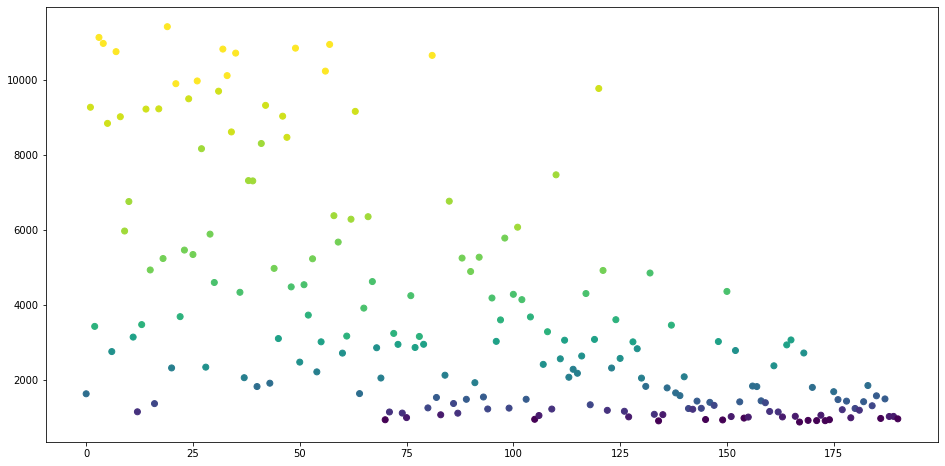

In [717]:
plt.figure(figsize=(16,8))
plt.scatter(data=df_all_item_top, x='index', y='view', c='view_q')#,c=clf.labels_)

#### Прогноз последовательности ряда

Гипотеза о том что следующие значения зависят от предыдущих, например

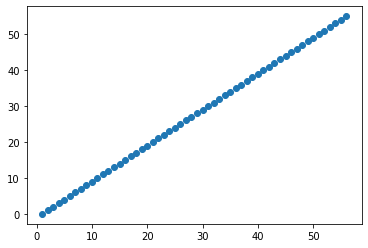

In [465]:
plt.scatter(data=df_train[df_train['user_id'] == 0], 
            x='order', y='item_id')

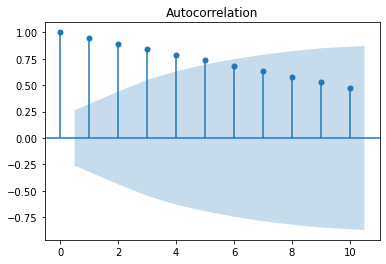

In [339]:
plot_acf(df_train[df_train['user_id'] == 0]['item_id'], lags=10);

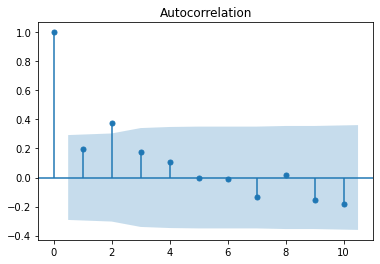

In [241]:
plot_acf(df_train[df_train['user_id'] == 3]['item_id'], lags=10);

In [353]:
df_train_item_X = pd.DataFrame(data_to_train.pivot_table(index='user_id', columns='item_id', values='order',
                                                aggfunc='count', fill_value=0).to_records())
df_train_item_X.drop('user_id', axis=1, inplace=True)
df_train_item_X.columns = list(map(lambda x: 'i{}'.format(x), list(range(0, len(df_train_item_X.columns), 1))))

df_train_item_X

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,...,i181,i182,i183,i184,i185,i186,i187,i188,i189,i190
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1,1,0,1,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
14996,0,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,1,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
14998,0,0,0,1,0,0,1,1,1,0,...,1,0,0,0,0,0,1,0,0,0


In [373]:
users_id_filtered[714]

716

In [374]:
df_train[df_train['user_id'] == 716][['item_id']]

,item_id
33310,150
33311,97
33312,57
33313,52
33314,58
33315,120
33316,36


In [376]:
n_shift = 5 #количество стобцов со смещением
recomendaciones = []
users_id_filtered = df_train_item_X[df_train_item_X.sum(axis=1)>n_shift].index #пользователи у которых больше n_shift просмотров

for user_id in tqdm(users_id_filtered):
    df_shift = df_train[df_train['user_id'] == user_id][['item_id']]
    for s in range(1, n_shift+1):
        df_shift['shift{}'.format(s)] = df_shift['item_id'].shift(periods=s).fillna(0).astype(int)
        df_shift_X = df_shift[n_shift:].drop('item_id', axis=1)
        df_shift_y = df_shift[n_shift:]['item_id']
    model = LinearRegression()
    #X_tmp = df_shift_X[:-2] #для валидации беру все кроме 3х последних
    #y_tmp = df_shift_y[:-2]
    X_tmp = df_shift_X #для теста беру все
    y_tmp = df_shift_y 
    model.fit(X_tmp, y_tmp)
    for i in list(map(round, model.predict(df_shift_X[-3:]))): #предсказываю на последних 3 значениях
        recomendaciones.append(i)

  0%|          | 0/14989 [00:00<?, ?it/s]

In [ ]:
#params = {
#            "n_estimators": [100],
#            "max_depth": np.linspace(1, 32, 20, endpoint=True),
#            "max_features": [X_train.shape[1],int(X_train.shape[1]/2)] 
#         }

In [197]:
#combinations = it.product(*(params[Name] for Name in params))

#for comb in combinations:  
    #model = RandomForestClassifier(n_estimators=comb[0], max_depth=comb[1], max_features=comb[2])
    #model.fit(df_shift_X[:-3], df_shift_y[:-3])
    #model.predict(df_shift_X[-3:])

In [378]:
len(recomendaciones)

44944

In [379]:
df_valid_ACF = df_valid[:len(recomendaciones)].copy()
df_valid_ACF['item_id'] = recomendaciones
calc_map_k(df_valid[:len(recomendaciones)], df_valid_ACF) * 1000

3.978848692505079

In [138]:
pred_users = get_success_pred_user_id(pred_users, 'ACF', df_valid, df_valid_ACF)

  0%|          | 0/14993 [00:00<?, ?it/s]

#### Итоги по сумме прогнозов по всем методам выше. Уникальных пользователей для которых метрика положительня

In [ ]:
pred_users_copy = pred_users.copy()

In [418]:
#для экспериментов
pred_users_tmp = {'m1':{1:100, 2:200},
                  'm2':{2:100, 3:300},
                  'm3':{3:200, 4:300},
                 }

In [180]:
pred_users = pred_users_copy

In [417]:
unique_pred_users_id = {} #Уникальные пользователи с каждого метода для которых дана успешная оценка
summ_all = 0
summ_unique = 0
unique_users = set()

for key in pred_users.keys():
    summ_all += len(pred_users[key]) #пользователи по которым успешная оценка
    unique_users_id_key = list(set(pred_users[key].keys()) - unique_users)
    unique_users = unique_users | set(pred_users[key].keys()) #уникальные пользователи нарастающий итог
    #summ_unique += len(list(unique_users))
    print(len(pred_users[key]), summ_all, len(unique_users_id_key), len(list(unique_users)), key)
    unique_pred_users_id[key] = unique_users_id_key

1702 1702 1702 1702 UFeatures_k150
496 2198 407 2109 ALS
1483 3681 928 3037 Cosine
247 3928 196 3233 ACF
1473 5401 41 3274 CosineScaled


##### Отберу с каждого метода пользователей для которых дана положительная оценка но которых нет в предыдущем методе

Возьму лучший результат - UFeatures_k150 и буду там заменять прогнозы тех пользователей ИД которых есть только в других методах, где оценка положительная.

In [405]:
dict_valid = {'ALS':df_valid_ALS, 
              'Cosine':df_valid_Cosine,
              'CosineScaled':df_valid_CosineScaled,
              'ACF':df_valid_ACF,
             }

In [406]:
df_valid_merge = df_valid_UFeatures_k150.copy()

In [413]:
for method in dict_valid.keys():
    user_id_new_pred = unique_pred_users_id[method]
    data = dict_valid[method]
    new_pred = data[data['user_id'].isin(user_id_new_pred)]
    df_valid_merge[df_valid_merge['user_id'].isin(user_id_new_pred)] = new_pred

In [415]:
#df_valid_merge.to_csv(r'Data/out_4.csv', index=False) #df_valid_merge1: очков =  из 235 место на лидерборде (максимум 386.407)

Поменяю ключи в словаре местами в зависимости от оценки на валидации (сортирую по убыванию)

In [425]:
pred_users_keys_sort = ['UFeatures_k150', 'Cosine', 'CosineScaled', 'ALS', 'ACF']

In [426]:
unique_pred_users_id = {} #Уникальные пользователи с каждого метода для которых дана успешная оценка
summ_all = 0
summ_unique = 0
unique_users = set()

for key in pred_users_keys_sort:
    summ_all += len(pred_users[key]) #пользователи по которым успешная оценка
    unique_users_id_key = list(set(pred_users[key].keys()) - unique_users)
    unique_users = unique_users | set(pred_users[key].keys()) #уникальные пользователи нарастающий итог
    #summ_unique += len(list(unique_users))
    print(len(pred_users[key]), summ_all, len(unique_users_id_key), len(list(unique_users)), key)
    unique_pred_users_id[key] = unique_users_id_key

1702 1702 1702 1702 UFeatures_k150
1483 3185 1018 2720 Cosine
1473 4658 47 2767 CosineScaled
496 5154 311 3078 ALS
247 5401 196 3274 ACF


In [427]:
df_valid_merge = df_valid_UFeatures_k150.copy()

In [428]:
for method in dict_valid.keys():
    user_id_new_pred = unique_pred_users_id[method]
    data = dict_valid[method]
    new_pred = data[data['user_id'].isin(user_id_new_pred)]
    df_valid_merge[df_valid_merge['user_id'].isin(user_id_new_pred)] = new_pred

In [429]:
#df_valid_merge.to_csv(r'Data/out_5.csv', index=False) #df_valid_merge_sort: очков =  из 235 место на лидерборде (максимум 386.407)

Добавил еще методов

In [460]:
pred_users['TopItem']

{}

In [457]:
pred_users.keys()

dict_keys(['UFeatures_k150', 'ALS', 'Cosine', 'ACF', 'CosineScaled', 'TopItem', 'TopItemOrder'])

In [458]:
pred_users_keys_sort = ['UFeatures_k150', 'TopItem', 'TopItemOrder', 'Cosine', 'CosineScaled', 'ALS', 'ACF']

In [489]:
unique_pred_users_id = {} #Уникальные пользователи с каждого метода для которых дана успешная оценка
summ_all = 0
summ_unique = 0
unique_users = set()

for key in pred_users_keys_sort:
    summ_all += len(pred_users[key]) #пользователи по которым успешная оценка
    unique_users_id_key = list(set(pred_users[key].keys()) - unique_users)
    unique_users = unique_users | set(pred_users[key].keys()) #уникальные пользователи нарастающий итог
    #summ_unique += len(list(unique_users))
    print(len(pred_users[key]), summ_all, len(unique_users_id_key), len(list(unique_users)), key)
    unique_pred_users_id[key] = unique_users_id_key

1702 1702 1702 1702 UFeatures_k150
1504 3206 1028 2730 TopItem
365 3571 291 3021 TopItemOrder
1483 5054 340 3361 Cosine
1473 6527 23 3384 CosineScaled
496 7023 281 3665 ALS
247 7270 189 3854 ACF


In [490]:
dict_valid = {'ALS':df_valid_ALS, 
              'Cosine':df_valid_Cosine,
              'CosineScaled':df_valid_CosineScaled,
              'ACF':df_valid_ACF,
              'TopItem':df_valid_TopItem,
              'TopItemOrder':df_valid_TopItemOrder
             }

In [492]:
df_valid_merge = df_valid_UFeatures_k150.copy()

for method in dict_valid.keys():
    print(method)
    user_id_new_pred = unique_pred_users_id[method]
    data = dict_valid[method]
    new_pred = data[data['user_id'].isin(user_id_new_pred)]
    df_valid_merge[df_valid_merge['user_id'].isin(user_id_new_pred)] = new_pred

ALS
Cosine
CosineScaled
ACF
TopItem
TopItemOrder


In [493]:
df_valid_merge.to_csv(r'Data/out_6.csv', index=False) #df_valid_merge_sort2: очков =  из 235 место на лидерборде (максимум 386.407)

#### Рейтинги статей

In [42]:
top_items = df_item_top.sum(axis=1).sort_values(ascending=False)
top_items

19     11415
3      11129
4      10969
57     10942
49     10843
       ...  
169      922
171      916
173      914
134      909
167      878
Length: 191, dtype: int64

In [55]:
df_train_item_X = pd.DataFrame(df_train_sh.pivot_table(index='user_id', columns='item_id', values='item_id',
                                                aggfunc='count', fill_value=0).to_records())
df_train_item_X.drop('user_id', axis=1, inplace=True)
#df_train_order_X.columns = list(map(lambda x: 'o{}'.format(x), list(range(0, len(df_train_order_X.columns), 1))))

df_train_item_X

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,1,0,1,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
14996,0,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,1,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
14998,0,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0


In [56]:
for col in df_train_item_X.columns:
    di = {1:top_items.loc[int(col)], 0: 0}
    df_train_item_X = df_train_item_X.replace({col: di})

In [57]:
df_train_item_X

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1631,9268,3427,11129,10969,8838,2756,10750,9015,5969,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,10750,9015,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3427,11129,10969,0,0,10750,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,9268,0,11129,0,8838,0,10750,9015,0,...,0,0,0,0,0,0,0,0,0,0
4,0,9268,0,0,10969,0,0,10750,9015,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,9268,0,11129,10969,8838,0,10750,0,0,...,1193,0,0,0,0,0,0,0,0,0
14996,0,9268,3427,11129,10969,8838,0,10750,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,8838,2756,10750,0,0,...,0,0,1851,1312,0,0,0,0,0,0
14998,0,0,0,11129,0,0,2756,10750,0,0,...,1193,0,0,0,0,0,1494,0,0,0


Использовал заготовки выше на новых данных.  

ALS : 6.73973293020912  
Cosine: 22.55346583077675  
Cosine_scaled: 22.431194700102267  

#### Расширенная матрица

Сделаю матрицу из статей ордеров и информации о пользователе по каждой статье отдельно

In [90]:
df_train.head()

,user_id,item_id,order
0,0,0,1
1,0,1,2
2,0,2,3
3,0,3,4
4,0,4,5


In [92]:
pd.get_dummies(df_train['item_id'].head())

,0,1,2,3,4
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,0,1


In [93]:
pd.get_dummies(df_train['order'].head())

,1,2,3,4,5
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,0,1


In [101]:
pd.concat([df_train.head()[['user_id']]
           , pd.get_dummies(df_train['item_id'].head())
           , pd.get_dummies(df_train['order'].head())
           , df_train.head()['item_id'].shift(-1)]
          , axis=1)

,user_id,0,1,2,3,4,1,2,3,4,5,item_id
0,0,1,0,0,0,0,1,0,0,0,0,1.0
1,0,0,1,0,0,0,0,1,0,0,0,2.0
2,0,0,0,1,0,0,0,0,1,0,0,3.0
3,0,0,0,0,1,0,0,0,0,1,0,4.0
4,0,0,0,0,0,1,0,0,0,0,1,NaN


Подготавливаю данные для большой матрицы

In [105]:
df_item_dummies = pd.get_dummies(df_train['item_id'])

In [107]:
df_order_dummies = pd.get_dummies(df_train['order'])

In [149]:
users_next_items = []
for user_id in df_train['user_id'].unique():
    users_next_items += [v for v in df_train[df_train['user_id'] == user_id]['item_id'].shift(-1).values]

In [154]:
df_next_item = pd.DataFrame(users_next_items, columns=['next_item'])

In [173]:
df_dummies = pd.concat([df_train[['user_id', 'item_id']]
           , df_item_dummies
           , df_order_dummies
           , df_next_item]
           , axis=1)

In [174]:
#Данные с нулевыми next_id будут использовться для предсказания
df_test_data = df_dummies.loc[df_dummies['next_item'].index[df_dummies['next_item'].apply(np.isnan)]]
df_test_data.tail()

,user_id,item_id,0,1,2,3,4,5,6,7,...,57,58,59,60,61,62,63,64,65,next_item
704869,14995,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
704914,14996,53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
704960,14997,104,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
705012,14998,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
705065,14999,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [175]:
df_train_data = df_dummies.loc[df_dummies['next_item'].index[~df_dummies['next_item'].apply(np.isnan)]]
df_train_data['next_item'] = df_train_data['next_item'].astype(int)
df_train_data.tail()

,user_id,item_id,0,1,2,3,4,5,6,7,...,57,58,59,60,61,62,63,64,65,next_item
705060,14999,69,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27
705061,14999,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,124
705062,14999,124,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,160
705063,14999,160,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
705064,14999,49,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [176]:
params = {
            "n_estimators":[2000],
            "max_depth": np.linspace(10, 200, 20, endpoint=True),
            "max_feature":["sqrt", 256],
            "min_samples_leaf": range(1, 6, 1)
}


In [ ]:
combinations = it.product(*(params[Name] for Name in params))

In [185]:
for comb in tqdm(combinations):
    clf = RandomForestClassifier(n_estimators=comb[0],
                                 max_depth=comb[1],
                                 max_features=comb[2],
                                 min_samples_leaf=comb[3],
                                )
    X_train_data = df_train_data.drop(['user_id', 'item_id', 'next_item'], axis=1)
    clf.fit(X_train_data, df_train_data['next_item'])
    print('1')
    X_test_data = df_test_data.drop(['user_id', 'item_id', 'next_item'], axis=1)
    test_pred = clf.predict(X_test_data)
    test_real = df_test_data['item_id']
    
    break

0it [00:00, ?it/s]

1


In [187]:
test_pred = clf.predict(X_test_data)

In [188]:
test_pred

array([19, 19, 18, ..., 19, 81, 19])